# Tenjin Temporal Stability 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import skimage.io
import glob
import sys
sys.path.insert(0, '../../../../')
import mwc.viz
import mwc.stats
colors = mwc.viz.personal_style()
%matplotlib inline

##  The problem

I did an experiment on 20180215 that compared the temporal stability of the three illumination light sources. I found that the LED seemed to be the most stable save for periodic jumps in intensity. This could be from the frequency noise of the LED itself or spiking that occurs from turning the LED on and off. To see if I could remove these periodic impulses, I took several data sets of a fluorescent slide fixed on a single position. I took movies of 100 frames with a 50ms exposure and 100ms dwell time. I took this both with software shutter control on and off. Here, I look at those images. 

##  Image Processing

In [12]:
# Define the data directory and load the data.
data_dir = '../../../../data/images/20180219_tenjin_shutter_control'
modes = ['on', 'off']

# Set up the dataframe. 
df = pd.DataFrame([], columns=['shutter', 'position', 'frame',
                               'mean_intensity', 'total_intensity'])

# Loop through the modes and collect all of the images. 
for i, m in enumerate(modes):
    files = glob.glob('{}/*_{}*.TIF'.format(data_dir, m))
    for j, f in enumerate(files):
        # Determine the position and frame number information.
        im_name = f.split('/')[-1]
        time = int(im_name.split('_t')[1].split('.TIF')[0])
        pos_str = im_name.split('_')[-3]
        try:
            pos = int(pos_str.split('{}'.format(m))[1])
        except:
            pos = 0
       
        # Load the image.
        im = skimage.io.imread(f)
        
        # Compute the properties of interest and add them to the DF.
        mean_intensity = np.mean(im)
        total_intensity = np.sum(im)
        slide_dict = {'shutter': m, 'position':pos, 'frame':time, 
                     'mean_intensity':mean_intensity, 
                      'total_intensity':total_intensity}
        df = df.append(slide_dict, ignore_index=True)  

In [16]:
# Save the dataframe to a csv file
df.to_csv('output/20180219_tenjin_shutter_control.csv', index=False)

##  Comparison

Let's just plot the individual traces together.

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


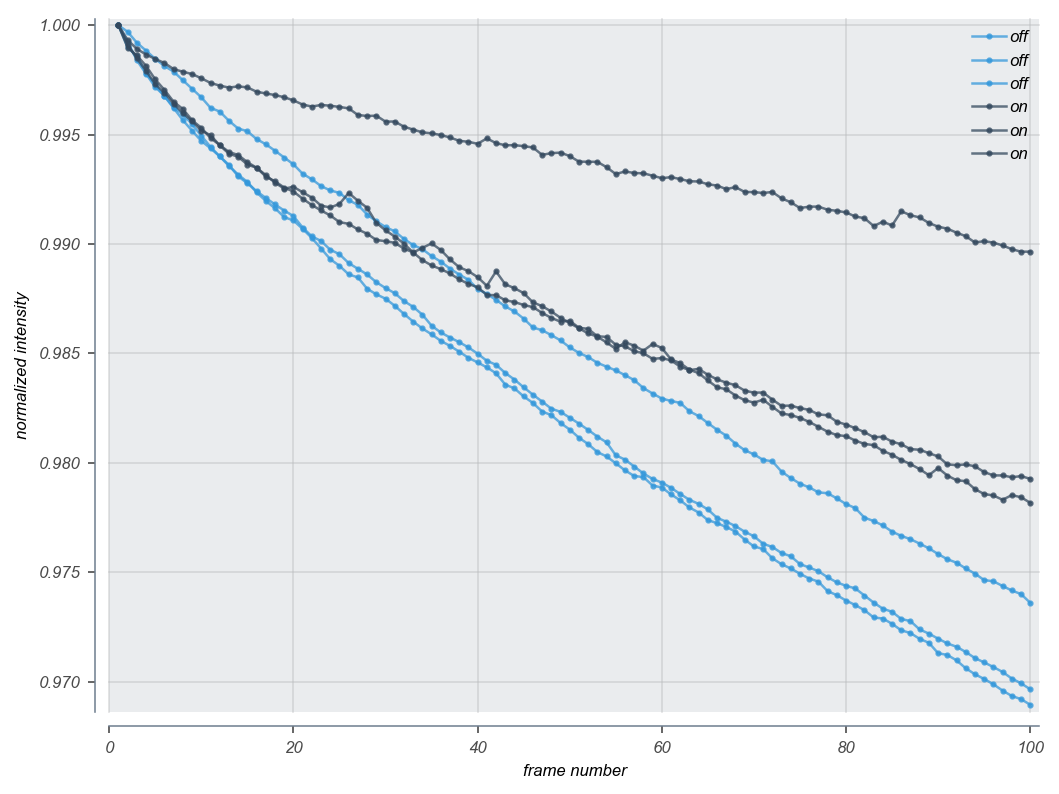

In [21]:
# Group by the shutter mode
grouped = df.groupby(['shutter', 'position'])

# Set up the figure axis. 
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('frame number')
ax.set_ylabel('normalized intensity')
color_key = {'on': colors[0], 'off': colors[2]}
for g, d in grouped:
    d.sort_values('frame', inplace=True)
    _ = ax.plot(d['frame'], d['total_intensity'] / d.iloc[0]['total_intensity'], '-o', ms=2,
               color=color_key[g[0]], alpha=0.75, label=g[0])
_ = ax.legend()
mwc.viz.format_axes()

The intensity jumps seem to be much less severe than the other day, which I guess is a good thing. There are still large changes for the case in which the shutter control is on. To more accurately quantify this, we'll now  compute the percent difference for each one. 

In [39]:
def perc_diff(d):
    return (np.diff(d) / d[:-1]) * 100

diff_df = grouped['total_intensity'].apply(perc_diff)

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


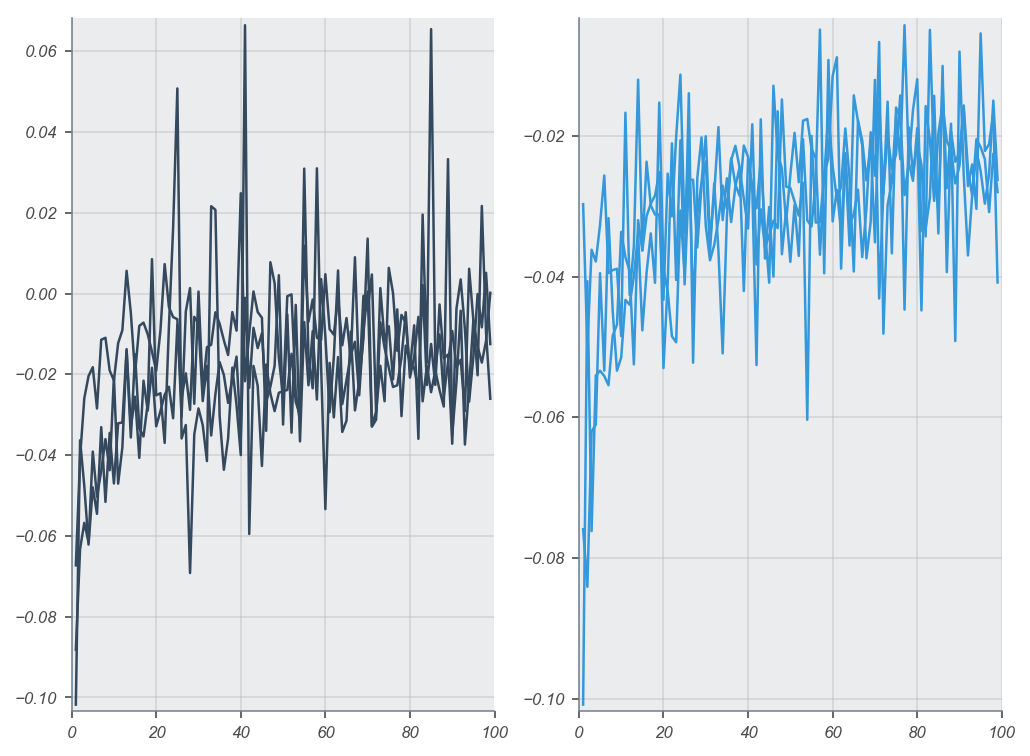

In [41]:
fig, ax = plt.subplots(1, 2)
axes = {'on': ax[0], 'off': ax[1]}
for g, d in grouped:
    d.sort_values('frame', inplace=True)
    diff = (np.diff(d['total_intensity']) / d.iloc[:-1]['total_intensity']) * 100
    axes[g[0]].plot(d.iloc[:-1]['frame'], diff, color=color_key[g[0]])    

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


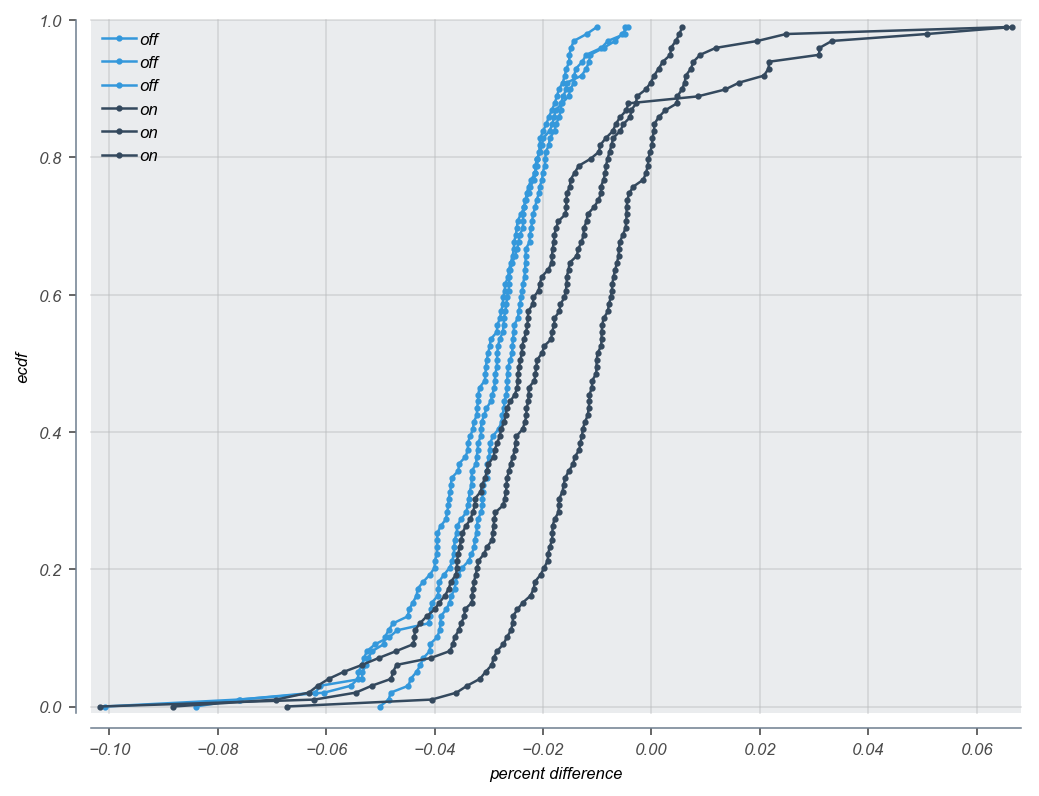

In [51]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('percent difference')
ax.set_ylabel('ecdf')
for g, d in grouped:
    d.sort_values('frame', inplace=True)
    diff = (np.diff(d['mean_intensity']) / d.iloc[:-1]['mean_intensity']) * 100
    x, y = mwc.stats.ecdf(diff)
    _ =  ax.plot(x, y, '-o', ms=2, color=color_key[g[0]], label=g[0])
_ = ax.legend()
mwc.viz.format_axes()

##  Testing induction of LED

In [73]:
# Set up the dataframe. 
two_chan_df = pd.DataFrame([], columns=['shutter', 'position', 'frame',
                               'mean_intensity', 'total_intensity', 'chan'])

# Loop through the modes and collect all of the images. 
for i, m in enumerate(modes):
    files = glob.glob('{}/*two_channel*_{}*.TIF'.format(data_dir, m))
    for j, f in enumerate(files):
        # Determine the position and frame number information.
        im_name = f.split('/')[-1]
        time = int(im_name.split('_t')[2].split('.TIF')[0])
        pos_str = im_name.split('_')[-3]
        chan = im_name.split('_')[-2].split('w')[1][1:]
        try:
            pos = int(pos_str.split('{}'.format(m))[1])
        except:
            pos = 0
       
        # Load the image.
        im = skimage.io.imread(f)
        
        # Compute the properties of interest and add them to the DF.
        mean_intensity = np.mean(im)
        total_intensity = np.sum(im)
        slide_dict = {'shutter': m, 'position':pos, 'frame':time, 
                     'mean_intensity':mean_intensity, 
                      'total_intensity':total_intensity,
                     'chan':chan}
        two_chan_df = two_chan_df.append(slide_dict, ignore_index=True)  

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


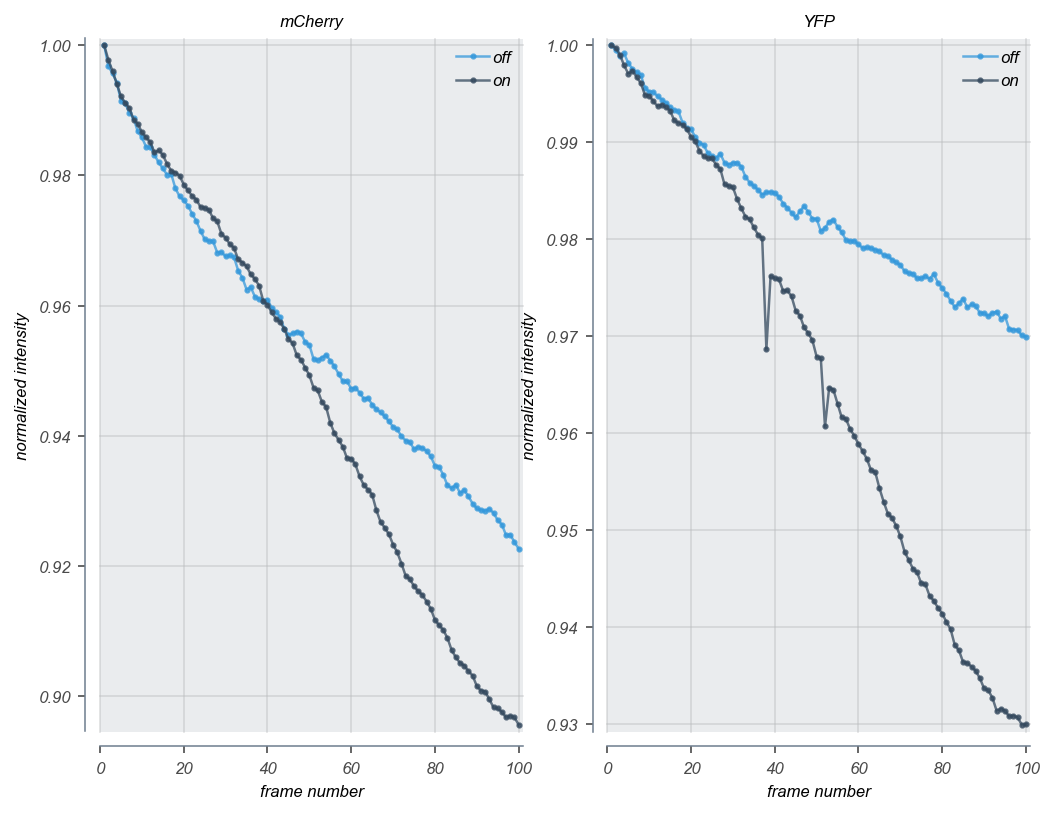

In [78]:
# Group by the shutter mode
grouped = two_chan_df.groupby(['chan', 'shutter', 'position'])

# Set up the figure axis. 
fig, ax = plt.subplots(1, 2)
axes = {'mCherry':ax[0], 'YFP':ax[1]}
ax[0].set_xlabel('frame number')
ax[1].set_xlabel('frame number')
ax[0].set_ylabel('normalized intensity')
ax[1].set_ylabel('normalized intensity')
ax[0].set_title('mCherry')
ax[1].set_title('YFP')
color_key = {'on': colors[0], 'off': colors[2]}
for g, d in grouped:
    d.sort_values('frame', inplace=True)
    _ = axes[g[0]].plot(d['frame'], d['total_intensity'] / d.iloc[0]['total_intensity'], '-o', ms=2,
               color=color_key[g[1]], alpha=0.75, label=g[1])
_ = ax[0].legend()
_ = ax[1].legend()
mwc.viz.format_axes()

In [74]:
mch_df = two_chan_df[two_chan_df['chan']=='mCherry']

,shutter,position,frame,mean_intensity,total_intensity,chan
0,on,0,36,1058.009104,5850367139,YFP
1,on,0,22,1067.364213,5902097154,YFP
2,on,0,1,2688.045272,14863815137,mCherry
3,on,0,4,1076.863511,5954624468,YFP
4,on,0,87,2431.865429,13447243077,mCherry
5,on,0,93,2417.906328,13370054830,mCherry
6,on,0,44,2570.911092,14216109976,mCherry
7,on,0,50,2551.756268,14110191459,mCherry
8,on,0,100,1003.457457,5548718353,YFP
9,on,0,78,2458.302930,13593431884,mCherry
